In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore') 
pd.set_option('display.max_columns', None)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [71]:
CFG = {
    'EPOCHS': 50,
    'LEARNING_RATE':1e-2,
    'BATCH_SIZE':256,
    'SEED':41
}

In [72]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

In [73]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [74]:
categorical_features = ['COMPONENT_ARBITRARY']#, 'YEAR']
# Inference(실제 진단 환경)에 사용하는 컬럼
test_stage_features = ['ANONYMOUS_1', 'ANONYMOUS_2', 'AG', 'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN']

In [75]:
train = train.drop(['YEAR'], axis = 1)
test = test.drop(['YEAR'], axis = 1)

In [39]:
mis_val = train.isnull().sum()
mis_val_bool = mis_val >= 1
mis_val_df = pd.concat([mis_val, mis_val_bool], axis = 1)
mis_val_df = mis_val_df.rename(columns = {0 : 'mis_val', 1 : 'mis_val_bool'})

print("결측이 있는 변수")
print(mis_val_df['mis_val_bool'].value_counts())

결측이 있는 변수
mis_val_bool
False    34
True     19
Name: count, dtype: int64


In [40]:
mis_val_data = mis_val_df.loc[mis_val_df['mis_val_bool'] == True, :]
mis_val_data['ratio'] = mis_val_data['mis_val'] / 14095
mis_val_data

,mis_val,mis_val_bool,ratio
CD,1394,True,0.098900
FH2O,10205,True,0.724016
FNOX,10205,True,0.724016
FOPTIMETHGLY,10205,True,0.724016
FOXID,10205,True,0.724016
FSO4,10205,True,0.724016
FTBN,10205,True,0.724016
FUEL,10205,True,0.724016
K,2299,True,0.163107
SOOTPERCENTAGE,10205,True,0.724016


In [41]:
notnull_columns = train.loc[:, train.notnull().sum(axis = 0) == 14095].columns
notnull_columns = notnull_columns[1 :]
notnull_columns = list(notnull_columns)

select_columns = notnull_columns[: 32] + ['K', 'CD'] + notnull_columns[32 :]
train = train.loc[:, select_columns]
print(train.shape)
print(train.columns)

(14095, 35)
Index(['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'SAMPLE_TRANSFER_DAY',
       'ANONYMOUS_2', 'AG', 'AL', 'B', 'BA', 'BE', 'CA', 'CO', 'CR', 'CU',
       'FE', 'H2O', 'LI', 'MG', 'MN', 'MO', 'NA', 'NI', 'P', 'PB', 'PQINDEX',
       'S', 'SB', 'SI', 'SN', 'TI', 'V', 'V40', 'ZN', 'K', 'CD', 'Y_LABEL'],
      dtype='object')


In [76]:
train = train.fillna(0)
test = test.fillna(0)

In [48]:
train_X

,ANONYMOUS_1,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,CA,CO,CR,CU,FE,H2O,LI,MG,MN,MO,NA,NI,P,PB,PQINDEX,S,SB,SI,SN,TI,V,V40,ZN,K,CD,COMPONENT1,COMPONENT2,COMPONENT3,COMPONENT4
6224,-0.069099,0.116588,-0.337936,-0.151896,-0.101686,0.678118,-0.228777,-0.042583,1.220967,-0.087612,-0.113358,-0.261477,-0.314001,-0.044504,-0.10941,-0.270107,-0.235440,-0.398820,-0.208246,-0.189712,-1.043886,-0.154584,-0.263715,-1.105093,-0.184755,-0.175244,0.783891,-0.097491,-0.113111,-0.755923,-0.284106,-0.198039,-0.06603,0,1,0,0
1786,-0.413153,-0.225434,0.293370,-0.151896,-0.125019,-0.549336,0.102931,-0.042583,-0.780446,-0.087612,-0.043191,-0.214906,-0.283485,-0.044504,0.32653,-0.182968,-0.235440,1.918859,-0.208246,-0.189712,0.066496,-0.154584,-0.259153,-0.625465,0.617902,-0.131071,0.039447,-0.097491,-0.113111,0.083483,1.384500,0.750812,-0.06603,1,0,0,0
2999,-0.413435,-0.396445,-0.013264,-0.151896,-0.113352,0.127214,-0.228777,-0.042583,1.283110,-0.087612,-0.113358,-0.253715,-0.314001,-0.044504,-0.10941,-0.148112,-0.235440,0.168094,-0.208246,-0.189712,-0.006345,-0.061985,-0.266974,-1.003650,-0.184755,-0.150703,-0.332775,-0.097491,-0.113111,-0.114024,0.801991,-0.008269,-0.06603,1,0,0,0
12302,-0.003954,-0.567456,-0.337936,-0.151896,-0.125019,-0.597661,-0.228777,-0.042583,-0.906083,-0.087612,-0.008108,-0.253715,1.540321,-0.044504,0.32653,-0.182968,0.788237,-0.365472,-0.155563,-0.189712,0.913940,-0.154584,-0.058417,1.070625,1.019230,-0.072173,-0.332775,5.119013,-0.113111,0.891288,-0.998150,-0.198039,-0.06603,0,0,1,0
8063,-0.519754,-0.225434,-0.337936,-0.151896,-0.055021,-0.587996,0.434638,-0.042583,-0.905408,-0.087612,-0.078274,-0.230430,-0.290665,-0.044504,-0.10941,3.337463,-0.235440,2.185642,-0.050197,-0.189712,-0.036547,0.030615,-0.265019,-0.834578,-0.184755,-0.135979,0.783891,-0.097491,-0.113111,0.231613,0.873395,0.118245,-0.06603,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10754,0.061190,-0.225434,-0.337936,-0.151896,-0.113352,3.683932,-0.228777,-0.042583,1.568833,-0.087612,-0.113358,-0.261477,-0.306821,-0.044504,-0.10941,-0.174254,-0.235440,3.819689,-0.050197,-0.189712,0.499989,-0.154584,-0.268929,-0.728626,-0.184755,-0.145795,-0.332775,-0.097491,-0.113111,0.049907,1.497244,-0.008269,-0.06603,1,0,0,0
11793,-0.406103,-0.310939,-0.337936,-0.151896,-0.113352,1.866913,-0.228777,-0.042583,1.208133,-0.087612,-0.043191,-0.245953,-0.290665,-0.044504,-0.10941,-0.182968,-0.235440,3.552906,-0.102880,-0.189712,0.384510,0.123214,-0.256546,-0.780367,-0.184755,-0.145795,0.039447,-0.097491,-0.113111,0.032131,1.499123,-0.008269,-0.06603,1,0,0,0
10052,0.304003,-0.396445,-0.337936,-0.151896,-0.148351,-0.549336,-0.228777,-0.042583,-0.911487,-0.087612,0.026975,0.848467,0.034245,-0.044504,-0.10941,-0.261393,0.020479,-0.398820,-0.050197,1.391556,0.029187,-0.154584,-0.193979,1.860381,-0.184755,-0.150703,-0.332775,-0.097491,-0.113111,0.707606,-0.868494,-0.134782,-0.06603,0,0,1,0
11805,-0.553595,-0.396445,-0.007853,-0.151896,-0.125019,-0.559001,0.766346,-0.042583,-0.178604,-0.087612,-0.078274,0.064521,-0.267329,-0.044504,-0.10941,7.938423,-0.235440,0.418203,-0.155563,-0.189712,0.285019,-0.154584,-0.265671,-0.920885,-0.184755,-0.121254,0.783891,-0.097491,-0.113111,-0.416210,1.207868,0.181501,-0.06603,1,0,0,0


In [77]:
dummies_col = []
for c in categorical_features:
    df = pd.get_dummies(train[c])
    train[df.columns] = df
    train = train.drop(c, axis=1)
    df = pd.get_dummies(test[c])
    test[df.columns] = df
    test = test.drop(c, axis=1)
    dummies_col.extend(df.columns)
test_stage_features.extend(dummies_col)

In [78]:
all_X = train.drop(['ID', 'Y_LABEL'], axis = 1)
#all_X = train.drop(['Y_LABEL'], axis = 1)
all_y = train['Y_LABEL']

test = test.drop(['ID'], axis = 1)

train_X, val_X, train_y, val_y = train_test_split(all_X, all_y, test_size=0.2, random_state=CFG['SEED'], stratify=all_y)

In [79]:
def get_values(value):
    return value.values.reshape(-1, 1)

for col in train_X.columns:
    if col not in dummies_col:
        scaler = StandardScaler()
        train_X[col] = scaler.fit_transform(get_values(train_X[col]))
        val_X[col] = scaler.transform(get_values(val_X[col]))
        if col in test.columns:
            test[col] = scaler.transform(get_values(test[col]))
            
le = LabelEncoder()
for col in dummies_col:    
    train_X[col] = le.fit_transform(train_X[col])
    val_X[col] = le.transform(val_X[col])
    if col in test.columns:
        test[col] = le.transform(test[col])

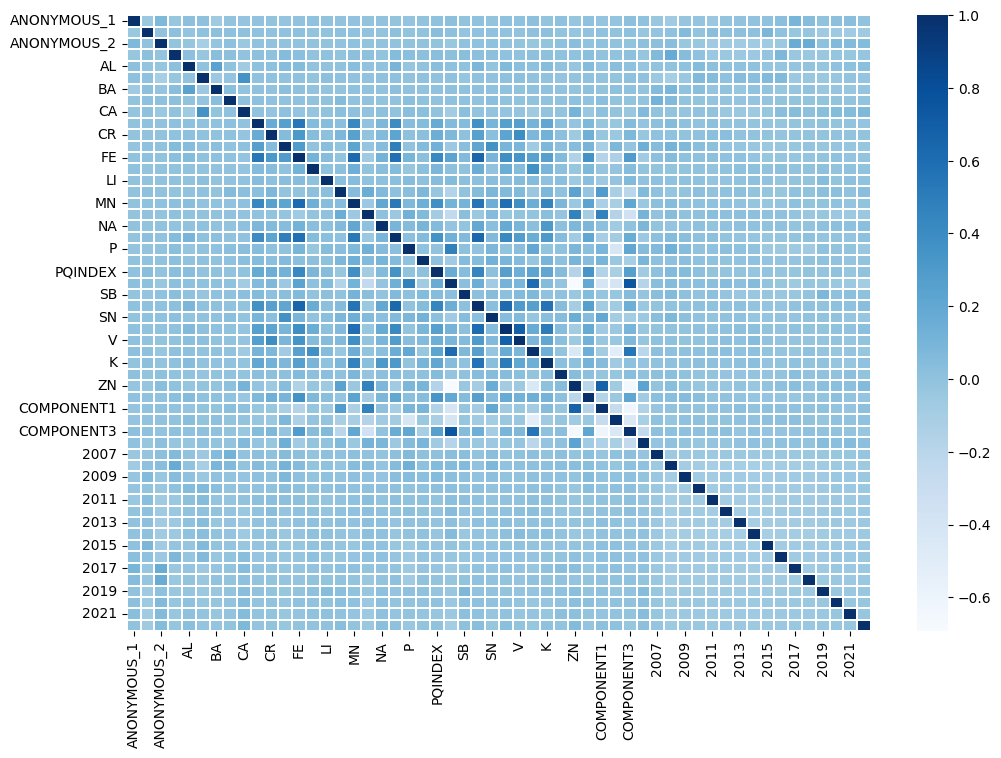

In [25]:
plt.figure(figsize = (12, 8))
x = sns.heatmap(train.corr(), cmap = 'Blues', linewidths = '0.1',annot = False)

In [239]:
pd.set_option('display.max_columns', None) 
cor = all_X.corr()
cor[cor>00.75]

,ANONYMOUS_1,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,CA,CO,CR,CU,FE,H2O,LI,MG,MN,MO,NA,NI,P,PB,PQINDEX,S,SB,SI,SN,TI,V,V40,K,CD,ZN,COMPONENT1,COMPONENT2,COMPONENT3,COMPONENT4,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
ANONYMOUS_1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAMPLE_TRANSFER_DAY,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANONYMOUS_2,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AG,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AL,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BA,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
class CustomDataset(Dataset):
    def __init__(self, data_X, data_y, distillation=False):
        super(CustomDataset, self).__init__()
        self.data_X = data_X
        self.data_y = data_y
        self.distillation = distillation
        
    def __len__(self):
        return len(self.data_X)
    
    def __getitem__(self, index):
        if self.distillation:
            # 지식 증류 학습 시
            teacher_X = torch.Tensor(self.data_X.iloc[index].values)
            student_X = torch.Tensor(self.data_X[test_stage_features].iloc[index].values)
            y = self.data_y.values[index]
            return teacher_X, student_X, y
        else:
            if self.data_y is None:
                test_X = torch.Tensor(self.data_X.iloc[index].values)
                return test_X
            else:
                teacher_X = torch.Tensor(self.data_X.iloc[index].values)
                y = self.data_y.values[index]
                return teacher_X, y

In [81]:
train_dataset = CustomDataset(train_X, train_y, False)
val_dataset = CustomDataset(val_X, val_y, False)

In [82]:
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [83]:
train_X

,ANONYMOUS_1,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,CA,CD,CO,CR,CU,FH2O,FNOX,FOPTIMETHGLY,FOXID,FSO4,FTBN,FE,FUEL,H2O,K,LI,MG,MN,MO,NA,NI,P,PB,PQINDEX,S,SB,SI,SN,SOOTPERCENTAGE,TI,U100,U75,U50,U25,U20,U14,U6,U4,V,V100,V40,ZN,COMPONENT1,COMPONENT2,COMPONENT3,COMPONENT4
6224,-0.069099,0.116588,-0.337936,-0.151896,-0.101686,0.678118,-0.228777,-0.042583,1.220967,-0.06603,-0.087612,-0.113358,-0.261477,-0.359401,-0.589503,-0.355339,-0.585942,-0.605969,-0.607530,-0.314001,-0.108366,-0.044504,-0.198039,-0.10941,-0.270107,-0.235440,-0.398820,-0.208246,-0.189712,-1.043886,-0.154584,-0.263715,-1.105093,-0.184755,-0.175244,0.783891,-0.383867,-0.097491,-0.074288,-0.097581,-0.070573,-0.045480,0.012590,0.149684,0.263073,0.501173,-0.113111,-0.595864,-0.755923,-0.284106,0,1,0,0
1786,-0.413153,-0.225434,0.293370,-0.151896,-0.125019,-0.549336,0.102931,-0.042583,-0.780446,-0.06603,-0.087612,-0.043191,-0.214906,1.081328,2.093840,2.074501,1.955765,1.988312,2.120598,-0.283485,-0.108366,-0.044504,0.750812,0.32653,-0.182968,-0.235440,1.918859,-0.208246,-0.189712,0.066496,-0.154584,-0.259153,-0.625465,0.617902,-0.131071,0.039447,1.870671,-0.097491,-0.074288,-0.097581,-0.070573,-0.116766,-0.116814,-0.128980,-0.122101,-0.170889,-0.113111,1.798817,0.083483,1.384500,1,0,0,0
2999,-0.413435,-0.396445,-0.013264,-0.151896,-0.113352,0.127214,-0.228777,-0.042583,1.283110,-0.06603,-0.087612,-0.113358,-0.253715,0.488087,0.901243,-0.355339,0.939082,1.231647,1.795225,-0.314001,2.083448,-0.044504,-0.008269,-0.10941,-0.148112,-0.235440,0.168094,-0.208246,-0.189712,-0.006345,-0.061985,-0.266974,-1.003650,-0.184755,-0.150703,-0.332775,-0.158414,-0.097491,-0.074288,-0.097581,-0.070573,-0.116766,-0.116814,-0.128980,-0.122101,-0.170889,-0.113111,1.649149,-0.114024,0.801991,1,0,0,0
12302,-0.003954,-0.567456,-0.337936,-0.151896,-0.125019,-0.597661,-0.228777,-0.042583,-0.906083,-0.06603,-0.087612,-0.008108,-0.253715,-0.359401,-0.589503,-0.355339,-0.585942,-0.605969,-0.607530,1.540321,-0.108366,-0.044504,-0.198039,0.32653,-0.182968,0.788237,-0.365472,-0.155563,-0.189712,0.913940,-0.154584,-0.058417,1.070625,1.019230,-0.072173,-0.332775,-0.383867,5.119013,-0.074288,-0.097581,-0.070573,-0.116766,-0.116814,-0.128980,-0.122101,-0.170889,-0.113111,-0.595864,0.891288,-0.998150,0,0,1,0
8063,-0.519754,-0.225434,-0.337936,-0.151896,-0.055021,-0.587996,0.434638,-0.042583,-0.905408,-0.06603,-0.087612,-0.078274,-0.230430,0.827082,1.199392,-0.355339,1.277977,1.339742,1.970426,-0.290665,-0.108366,-0.044504,0.118245,-0.10941,3.337463,-0.235440,2.185642,-0.050197,-0.189712,-0.036547,0.030615,-0.265019,-0.834578,-0.184755,-0.135979,0.783891,-0.158414,-0.097491,-0.074288,-0.097581,-0.070573,-0.116766,-0.116814,-0.128980,-0.122101,-0.170889,-0.113111,1.848706,0.231613,0.873395,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10754,0.061190,-0.225434,-0.337936,-0.151896,-0.113352,3.683932,-0.228777,-0.042583,1.568833,-0.06603,-0.087612,-0.113358,-0.261477,1.250826,2.093840,-0.355339,2.125213,1.555932,1.670081,-0.306821,-0.108366,-0.044504,-0.008269,-0.10941,-0.174254,-0.235440,3.819689,-0.050197,-0.189712,0.499989,-0.154584,-0.268929,-0.728626,-0.184755,-0.145795,-0.332775,-0.158414,-0.097491,-0.074288,-0.097581,-0.070573,-0.116766,-0.116814,-0.128980,-0.122101,-0.170889,-0.113111,1.765557,0.049907,1.497244,1,0,0,0
11793,-0.406103,-0.310939,-0.337936,-0.151896,-0.113352,1.866913,-0.228777,-0.042583,1.208133,-0.06603,-0.087612,-0.043191,-0.245953,1.166077,2.690139,2.074501,2.803001,2.096407,1.670081,-0.290665,-0.108366,-0.044504,-0.008269,-0.10941,-0.182968,-0.235440,3.552906,-0.102880,-0.189712,0.384510,0.123214,-0.256546,-0.780367,-0.184755,-0.145795,0.039447,1.419763,-0.097491,-0.074288,-0.097581,-0.070573,-0.116766,-0.116814,-0.128980,-0.122101,-0.170889,-0.113111,1.782187,0.032131,1.499123,1,0,0,0
10052,0.3040

In [84]:
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=54, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=256, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=1024, out_features=4096),
            nn.BatchNorm1d(4096),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=4096, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=1024, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.classifier(x)
        return output

In [85]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)

    best_score = 0
    best_model = None
    criterion = nn.BCELoss().to(device)

    for epoch in range(CFG["EPOCHS"]):
        train_loss = []
  
        model.train()
        for X, y in tqdm(train_loader):
            X = X.float().to(device)
            y = y.float().to(device)
            
            optimizer.zero_grad()
            
            y_pred = model(X)
            
            loss = criterion(y_pred, y.reshape(-1, 1))
            loss.backward()
            
            optimizer.step()

            train_loss.append(loss.item())

        val_loss, val_score = validation_teacher(model, val_loader, criterion, device)
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')

        if scheduler is not None:
            scheduler.step(val_score)
            
        if best_score < val_score:
            best_model = model
            best_score = val_score
        
    return best_model 

In [86]:
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro")

def validation_teacher(model, val_loader, criterion, device):
    model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = 0.35
    
    with torch.no_grad():
        for X, y in tqdm(val_loader):
            X = X.float().to(device)
            y = y.float().to(device)
            
            model_pred = model(X.to(device))
            
            loss = criterion(model_pred, y.reshape(-1, 1))
            val_loss.append(loss.item())      
            
            model_pred = model_pred.squeeze(1).to('cpu')  
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1   

In [87]:
model = Teacher()
model.eval()
#optimizer = torch.optim.SGD(model.parameters(), lr=CFG['LEARNING_RATE'])
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs', min_lr=1e-8, verbose=True)

teacher_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [0], Train Loss : [0.40143] Val Loss : [0.34407] Val F1 Score : [0.78184]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.34531] Val Loss : [0.31065] Val F1 Score : [0.79345]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.32751] Val Loss : [0.30431] Val F1 Score : [0.80480]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.34412] Val Loss : [0.34273] Val F1 Score : [0.79291]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.34162] Val Loss : [0.30081] Val F1 Score : [0.79981]
Epoch 00005: reducing learning rate of group 0 to 5.0000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.31595] Val Loss : [0.29329] Val F1 Score : [0.80144]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.30897] Val Loss : [0.29170] Val F1 Score : [0.81253]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.30595] Val Loss : [0.29520] Val F1 Score : [0.80302]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.29785] Val Loss : [0.29376] Val F1 Score : [0.81108]
Epoch 00009: reducing learning rate of group 0 to 2.5000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.28841] Val Loss : [0.28651] Val F1 Score : [0.81183]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.27761] Val Loss : [0.28383] Val F1 Score : [0.81060]
Epoch 00011: reducing learning rate of group 0 to 1.2500e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.29245] Val Loss : [0.28317] Val F1 Score : [0.81275]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.27925] Val Loss : [0.28197] Val F1 Score : [0.81342]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.28500] Val Loss : [0.28138] Val F1 Score : [0.81425]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.27129] Val Loss : [0.28344] Val F1 Score : [0.81383]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.26874] Val Loss : [0.29022] Val F1 Score : [0.81113]
Epoch 00016: reducing learning rate of group 0 to 6.2500e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.26749] Val Loss : [0.27941] Val F1 Score : [0.81449]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.27454] Val Loss : [0.28473] Val F1 Score : [0.81219]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.27263] Val Loss : [0.28229] Val F1 Score : [0.81425]
Epoch 00019: reducing learning rate of group 0 to 3.1250e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.26645] Val Loss : [0.28495] Val F1 Score : [0.81545]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.26126] Val Loss : [0.28077] Val F1 Score : [0.81236]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.27065] Val Loss : [0.27976] Val F1 Score : [0.81389]
Epoch 00022: reducing learning rate of group 0 to 1.5625e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.26049] Val Loss : [0.29058] Val F1 Score : [0.79965]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.27538] Val Loss : [0.28451] Val F1 Score : [0.81226]
Epoch 00024: reducing learning rate of group 0 to 7.8125e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.27172] Val Loss : [0.27694] Val F1 Score : [0.81280]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.28419] Val Loss : [0.27932] Val F1 Score : [0.81024]
Epoch 00026: reducing learning rate of group 0 to 3.9063e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.25961] Val Loss : [0.28313] Val F1 Score : [0.81416]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.26414] Val Loss : [0.28030] Val F1 Score : [0.80910]
Epoch 00028: reducing learning rate of group 0 to 1.9531e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.26979] Val Loss : [0.27737] Val F1 Score : [0.81204]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.26697] Val Loss : [0.28106] Val F1 Score : [0.81126]
Epoch 00030: reducing learning rate of group 0 to 9.7656e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.27055] Val Loss : [0.28620] Val F1 Score : [0.80474]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [31], Train Loss : [0.26168] Val Loss : [0.28529] Val F1 Score : [0.81162]
Epoch 00032: reducing learning rate of group 0 to 4.8828e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [32], Train Loss : [0.27633] Val Loss : [0.27810] Val F1 Score : [0.81461]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [33], Train Loss : [0.26164] Val Loss : [0.28212] Val F1 Score : [0.81362]
Epoch 00034: reducing learning rate of group 0 to 2.4414e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [34], Train Loss : [0.26213] Val Loss : [0.28947] Val F1 Score : [0.79661]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [35], Train Loss : [0.28742] Val Loss : [0.27790] Val F1 Score : [0.81343]
Epoch 00036: reducing learning rate of group 0 to 1.2207e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [36], Train Loss : [0.25934] Val Loss : [0.27945] Val F1 Score : [0.81100]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [37], Train Loss : [0.26099] Val Loss : [0.28155] Val F1 Score : [0.81196]
Epoch 00038: reducing learning rate of group 0 to 6.1035e-07.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [38], Train Loss : [0.26178] Val Loss : [0.28817] Val F1 Score : [0.80828]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [39], Train Loss : [0.27573] Val Loss : [0.27931] Val F1 Score : [0.81181]
Epoch 00040: reducing learning rate of group 0 to 3.0518e-07.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [40], Train Loss : [0.26719] Val Loss : [0.28162] Val F1 Score : [0.81094]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [41], Train Loss : [0.26154] Val Loss : [0.27740] Val F1 Score : [0.81599]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [42], Train Loss : [0.27375] Val Loss : [0.28289] Val F1 Score : [0.81043]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [43], Train Loss : [0.26932] Val Loss : [0.28077] Val F1 Score : [0.81389]
Epoch 00044: reducing learning rate of group 0 to 1.5259e-07.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [44], Train Loss : [0.25962] Val Loss : [0.28053] Val F1 Score : [0.81127]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [45], Train Loss : [0.26926] Val Loss : [0.28113] Val F1 Score : [0.81042]
Epoch 00046: reducing learning rate of group 0 to 7.6294e-08.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [46], Train Loss : [0.26492] Val Loss : [0.27805] Val F1 Score : [0.81024]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [47], Train Loss : [0.26622] Val Loss : [0.27987] Val F1 Score : [0.81367]
Epoch 00048: reducing learning rate of group 0 to 3.8147e-08.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [48], Train Loss : [0.27147] Val Loss : [0.28468] Val F1 Score : [0.81067]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [49], Train Loss : [0.26592] Val Loss : [0.28313] Val F1 Score : [0.81089]
Epoch 00050: reducing learning rate of group 0 to 1.9073e-08.


In [88]:
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=20, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=128, out_features=512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=1024, out_features=512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.classifier(x)
        return output

In [89]:
def distillation(student_logits, labels, teacher_logits, alpha):
    distillation_loss = nn.BCELoss()(student_logits, teacher_logits)
    student_loss = nn.BCELoss()(student_logits, labels.reshape(-1, 1))
    return alpha * student_loss + (1-alpha) * distillation_loss

In [90]:
def distill_loss(output, target, teacher_output, loss_fn=distillation, opt=optimizer):
    loss_b = loss_fn(output, target, teacher_output, alpha=0.1)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item()

In [91]:
def student_train(s_model, t_model, optimizer, train_loader, val_loader, scheduler, device):
    s_model.to(device)
    t_model.to(device)
    
    best_score = 0
    best_model = None

    for epoch in range(CFG["EPOCHS"]):
        train_loss = []
        s_model.train()
        t_model.eval()
        
        for X_t, X_s, y in tqdm(train_loader):
            X_t = X_t.float().to(device)
            X_s = X_s.float().to(device)
            y = y.float().to(device)
            
            optimizer.zero_grad()

            output = s_model(X_s)
            with torch.no_grad():
                teacher_output = t_model(X_t)
                
            loss_b = distill_loss(output, y, teacher_output, loss_fn=distillation, opt=optimizer)

            train_loss.append(loss_b)

        val_loss, val_score = validation_student(s_model, t_model, val_loader, distill_loss, device)
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_score)
            
        if best_score < val_score:
            best_model = s_model
            best_score = val_score
        
    return best_model

In [92]:
def validation_student(s_model, t_model, val_loader, criterion, device):
    s_model.eval()
    t_model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = 0.35
    
    with torch.no_grad():
        for X_t, X_s, y in tqdm(val_loader):
            X_t = X_t.float().to(device)
            X_s = X_s.float().to(device)
            y = y.float().to(device)
            
            model_pred = s_model(X_s)
            teacher_output = t_model(X_t)
            
            loss_b = distill_loss(model_pred, y, teacher_output, loss_fn=distillation, opt=None)
            val_loss.append(loss_b)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1    

In [93]:
train_dataset = CustomDataset(train_X, train_y, True)
val_dataset = CustomDataset(val_X, val_y, True)

train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [94]:
student_model = Student()
student_model.eval()
#optimizer = torch.optim.SGD(model.parameters(), lr=CFG['LEARNING_RATE'])
optimizer = torch.optim.Adam(student_model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs', min_lr=1e-8, verbose=True)

best_student_model = student_train(student_model, teacher_model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [0], Train Loss : [0.38700] Val Loss : [0.36508] Val F1 Score : [0.76516]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.34850] Val Loss : [0.34418] Val F1 Score : [0.77999]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.33948] Val Loss : [0.34067] Val F1 Score : [0.78268]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.34044] Val Loss : [0.34084] Val F1 Score : [0.78537]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.34360] Val Loss : [0.34358] Val F1 Score : [0.78654]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.33847] Val Loss : [0.34562] Val F1 Score : [0.78345]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.33196] Val Loss : [0.33928] Val F1 Score : [0.78189]
Epoch 00007: reducing learning rate of group 0 to 5.0000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.32682] Val Loss : [0.33427] Val F1 Score : [0.79477]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.32381] Val Loss : [0.33564] Val F1 Score : [0.78352]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.32080] Val Loss : [0.33295] Val F1 Score : [0.79498]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.31966] Val Loss : [0.33361] Val F1 Score : [0.79240]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.32330] Val Loss : [0.33716] Val F1 Score : [0.79091]
Epoch 00012: reducing learning rate of group 0 to 2.5000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.31993] Val Loss : [0.34003] Val F1 Score : [0.79731]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.32418] Val Loss : [0.33922] Val F1 Score : [0.79412]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.32067] Val Loss : [0.33376] Val F1 Score : [0.79616]
Epoch 00015: reducing learning rate of group 0 to 1.2500e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.31805] Val Loss : [0.35004] Val F1 Score : [0.80167]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.32096] Val Loss : [0.33502] Val F1 Score : [0.80147]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.31474] Val Loss : [0.33131] Val F1 Score : [0.79325]
Epoch 00018: reducing learning rate of group 0 to 6.2500e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.32084] Val Loss : [0.34317] Val F1 Score : [0.79964]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.31759] Val Loss : [0.34189] Val F1 Score : [0.79918]
Epoch 00020: reducing learning rate of group 0 to 3.1250e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.31631] Val Loss : [0.33728] Val F1 Score : [0.79877]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.31991] Val Loss : [0.34434] Val F1 Score : [0.80231]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.31825] Val Loss : [0.34207] Val F1 Score : [0.79861]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.32010] Val Loss : [0.33446] Val F1 Score : [0.79975]
Epoch 00024: reducing learning rate of group 0 to 1.5625e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.31534] Val Loss : [0.32908] Val F1 Score : [0.79129]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.31646] Val Loss : [0.33179] Val F1 Score : [0.79610]
Epoch 00026: reducing learning rate of group 0 to 7.8125e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.31849] Val Loss : [0.33070] Val F1 Score : [0.80147]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.31401] Val Loss : [0.33249] Val F1 Score : [0.79564]
Epoch 00028: reducing learning rate of group 0 to 3.9063e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.31528] Val Loss : [0.33643] Val F1 Score : [0.79788]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.31849] Val Loss : [0.33713] Val F1 Score : [0.79890]
Epoch 00030: reducing learning rate of group 0 to 1.9531e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.31637] Val Loss : [0.34516] Val F1 Score : [0.79990]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [31], Train Loss : [0.31853] Val Loss : [0.34554] Val F1 Score : [0.79909]
Epoch 00032: reducing learning rate of group 0 to 9.7656e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [32], Train Loss : [0.31868] Val Loss : [0.33239] Val F1 Score : [0.79947]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [33], Train Loss : [0.31660] Val Loss : [0.35531] Val F1 Score : [0.80007]
Epoch 00034: reducing learning rate of group 0 to 4.8828e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [34], Train Loss : [0.31873] Val Loss : [0.32979] Val F1 Score : [0.79869]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [35], Train Loss : [0.31906] Val Loss : [0.33080] Val F1 Score : [0.79647]
Epoch 00036: reducing learning rate of group 0 to 2.4414e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [36], Train Loss : [0.32352] Val Loss : [0.33183] Val F1 Score : [0.79493]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [37], Train Loss : [0.32396] Val Loss : [0.34489] Val F1 Score : [0.80110]
Epoch 00038: reducing learning rate of group 0 to 1.2207e-06.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [38], Train Loss : [0.31447] Val Loss : [0.32814] Val F1 Score : [0.79723]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [39], Train Loss : [0.31814] Val Loss : [0.33182] Val F1 Score : [0.79931]
Epoch 00040: reducing learning rate of group 0 to 6.1035e-07.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [40], Train Loss : [0.31615] Val Loss : [0.34872] Val F1 Score : [0.79699]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [41], Train Loss : [0.31482] Val Loss : [0.33049] Val F1 Score : [0.79568]
Epoch 00042: reducing learning rate of group 0 to 3.0518e-07.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [42], Train Loss : [0.31969] Val Loss : [0.34625] Val F1 Score : [0.79836]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [43], Train Loss : [0.31709] Val Loss : [0.34704] Val F1 Score : [0.79893]
Epoch 00044: reducing learning rate of group 0 to 1.5259e-07.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [44], Train Loss : [0.32993] Val Loss : [0.33767] Val F1 Score : [0.79012]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [45], Train Loss : [0.31613] Val Loss : [0.33089] Val F1 Score : [0.79699]
Epoch 00046: reducing learning rate of group 0 to 7.6294e-08.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [46], Train Loss : [0.31517] Val Loss : [0.33192] Val F1 Score : [0.79404]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [47], Train Loss : [0.31504] Val Loss : [0.32961] Val F1 Score : [0.79146]
Epoch 00048: reducing learning rate of group 0 to 3.8147e-08.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [48], Train Loss : [0.31455] Val Loss : [0.34517] Val F1 Score : [0.79916]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [49], Train Loss : [0.31570] Val Loss : [0.35041] Val F1 Score : [0.79826]
Epoch 00050: reducing learning rate of group 0 to 1.9073e-08.


In [95]:
def choose_threshold(model, val_loader, device):
    model.to(device)
    model.eval()
    
    thresholds = list(np.array(range(10, 51))/100) #[0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    pred_labels = []
    true_labels = []
    
    best_score = 0
    best_thr = None
    with torch.no_grad():
        for _, x_s, y in tqdm(iter(val_loader)):
            x_s = x_s.float().to(device)
            y = y.float().to(device)
            
            model_pred = model(x_s)
            
            model_pred = model_pred.squeeze(1).to('cpu')
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        for threshold in thresholds:
            pred_labels_thr = np.where(np.array(pred_labels) > threshold, 1, 0)
            score_thr = competition_metric(true_labels, pred_labels_thr)
            if best_score < score_thr:
                best_score = score_thr
                best_thr = threshold
    return best_thr, best_score

In [96]:
best_threshold, best_score = choose_threshold(best_student_model, val_loader, device)
print(f'Best Threshold : [{best_threshold}], Score : [{best_score:.5f}]')

  0%|          | 0/12 [00:00<?, ?it/s]

Best Threshold : [0.4], Score : [0.79952]


In [97]:
test_datasets = CustomDataset(test, None, False)
test_loaders = DataLoader(test_datasets, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [98]:
def inference(model, test_loader, threshold, device):
    model.to(device)
    model.eval()
    
    test_predict = []
    with torch.no_grad():
        for x in tqdm(test_loader):
            x = x.float().to(device)
            model_pred = model(x)

            model_pred = model_pred.squeeze(1).to('cpu')
            test_predict += model_pred
        
    test_predict = np.where(np.array(test_predict) > threshold, 1, 0)
    print('Done.')
    return test_predict

In [99]:
preds = inference(best_student_model, test_loaders, best_threshold, device)

  0%|          | 0/24 [00:00<?, ?it/s]

Done.


In [100]:
submit = pd.read_csv('./sample_submission.csv')
submit['Y_LABEL'] = preds
submit.head()

,ID,Y_LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0


In [101]:
submit.to_csv('./submit_baseline_onehot_epoch50_dropout_year.csv', index=False)